In [21]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
plt.style.use('dark_background')
from data_load_preprocess import data

import torch
from torch.autograd import Variable
SAVFIG = False

# load results from a directory

In [22]:
out_dir = '/scratch/users/vision/chandan/dl_theory/sweep_init_large'
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.convert_objects(convert_numeric=True)
# results_small.head()

/accounts/projects/vision/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


# compare losses by hidden layer dim

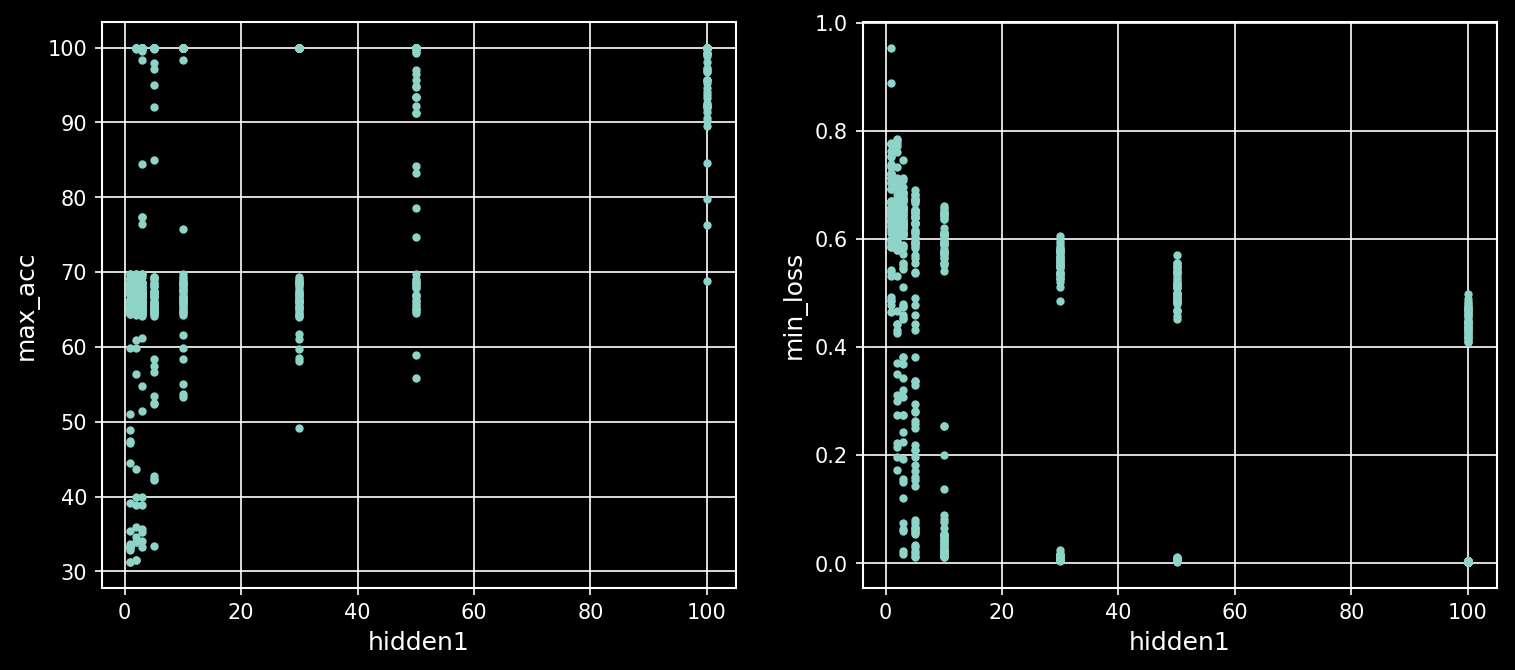

In [10]:
def lmplot(colx, coly, data=results, style='.', alpha=1., label=''):    
    plt.plot(data[colx], data[coly], style, alpha=alpha, label=label)
    plt.xlabel(colx)
    plt.ylabel(coly)
    if label!='':
        plt.legend(loc='best')

plt.figure(figsize=(12, 5), dpi=150)
plt.subplot(121)
lmplot('hidden1', 'max_acc')

plt.subplot(122)
lmplot('hidden1', 'min_loss')

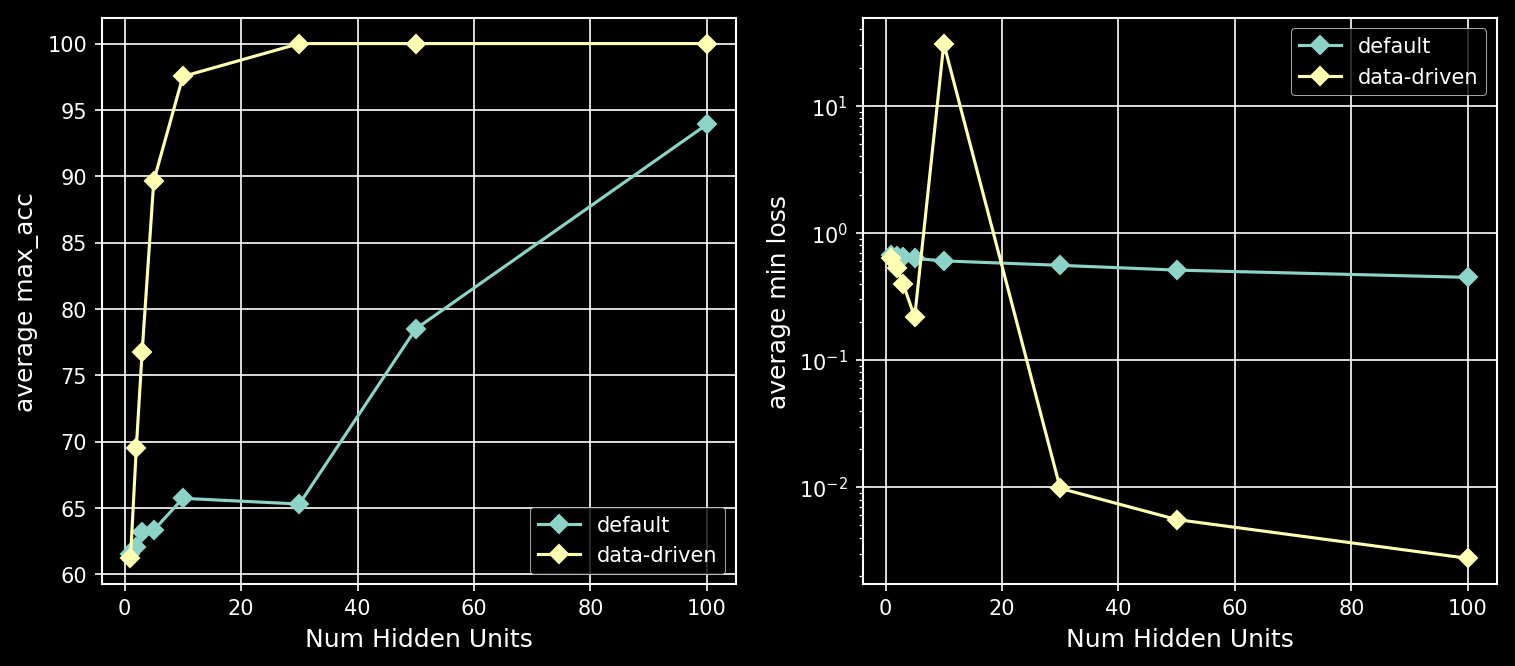

In [43]:
max_accs_default = results[results['init']=='default'][['max_acc', 'min_loss', 'hidden1']].groupby(['hidden1']).mean().reset_index()
max_accs_data = results[results['init']=='data-driven'][['max_acc', 'min_loss', 'hidden1']].groupby(['hidden1']).mean().reset_index()

plt.figure(figsize=(12, 5), dpi=150)
plt.subplot(121)
lmplot('hidden1', 'max_acc', max_accs_default, style='-D', label='default')
lmplot('hidden1', 'max_acc', max_accs_data, style='-D', label='data-driven')
plt.ylabel('average max_acc')
plt.xlabel('Num Hidden Units')

plt.subplot(122)
lmplot('hidden1', 'min_loss', max_accs_default, style='-D', label='default')
lmplot('hidden1', 'min_loss', max_accs_data, style='-D', label='data-driven')
# lmplot('hidden1', 'min_loss', max_accs_small, style='--o', label='small')
plt.ylabel('average min loss')
plt.xlabel('Num Hidden Units')
plt.yscale('log')
# SAVFIG = False
if SAVFIG == True:
    plt.savefig('performance_vs_hidden.pdf')
plt.show()

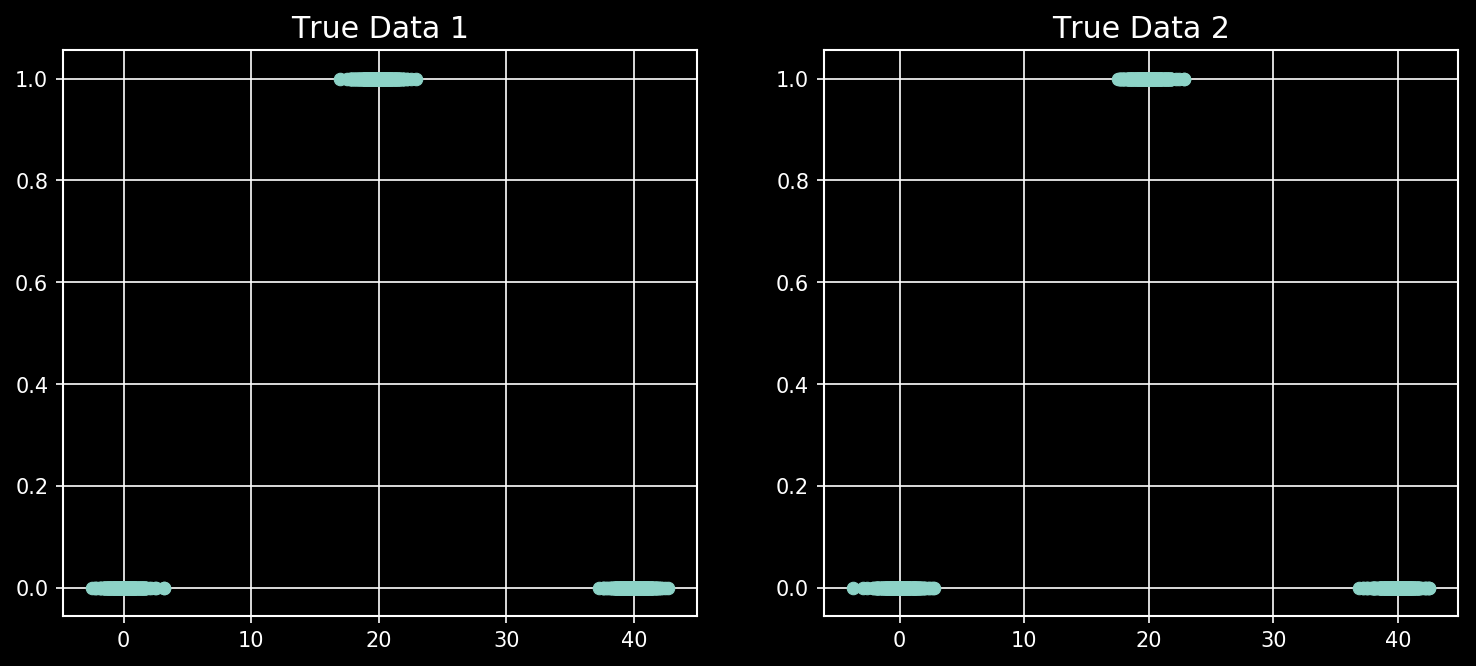

In [42]:
X, y, y_plot = data.generate_gaussian_data(results.N[0], means=results.means[0], sds=results.sds[0], labs=results.labs[0])
plt.figure(figsize=(12, 5), dpi=150)
plt.subplot(121)
plt.scatter(X.flatten(), y_plot.flatten())
plt.title('True Data 1')
X, y, y_plot = data.generate_gaussian_data(results.N[0], means=results.means[0], sds=results.sds[0], labs=results.labs[0])
plt.subplot(122)
plt.scatter(X.flatten(), y_plot.flatten())
plt.title('True Data 2')
if SAVFIG == True:
    plt.savefig('true_data.pdf')
plt.show()

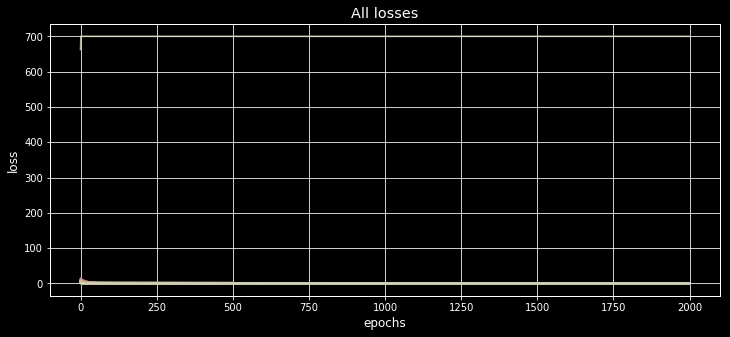

In [44]:
plt.figure(figsize=(12, 5))

loss_curves = np.array([np.array(x) for x in results['losses'].values if np.random.rand() < 2]) # filter by some amount
plt.plot(loss_curves.T, alpha=0.5)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('All losses')

plt.show()

# plot preds

In [89]:
# model = results['model'][0]
# X, y, y_plot = data.generate_gaussian_data(results['N'][0], means=results['means'][0], sds=results['sds'][0], labs=results['labs'][0])

# # plot predictions
# plt.figure(figsize=(5, 5), dpi=150)

# preds = model(Variable(torch.from_numpy(X), requires_grad=True)).data.numpy() # predict
# # plt.scatter(X, np.argmax(preds, axis=1), label='pred top class')
# X_grid = np.linspace(np.min(X), np.max(X), 1000, dtype=np.float32)
# X_grid = X_grid.reshape(X_grid.shape[0], 1)
# preds_grid = model(Variable(torch.from_numpy(X_grid), requires_grad=True)).data.numpy() # predict

# plt.scatter(X, y_plot, label='data labels', alpha=0.5, marker='x')
# plt.scatter(X_grid, preds_grid[:, 1], label='pred probability of class 1', color='orange') # note other class is 1 - this
# # plt.scatter(X_grid, preds_grid[:, 0], label='pred probability of class 0', color='green') # note other class is 1 - this
# plt.plot([-1000, 1000], [0.5, 0.5], '--')
# plt.xlim([np.min(X), np.max(X)])
# plt.legend()
# plt.show()

In [45]:
preds = results[['X_test', 'losses', 'pred_test','weights', 'max_acc', 'hidden1']].groupby(['hidden1'])

In [75]:
preds_small  = results_small[['X_test', 'losses', 'pred_test','weights', 'max_acc', 'hidden1']].groupby(['hidden1'])

In [25]:
xtest = results.X_test[0]
xtest_small = results_small.X_test[0]

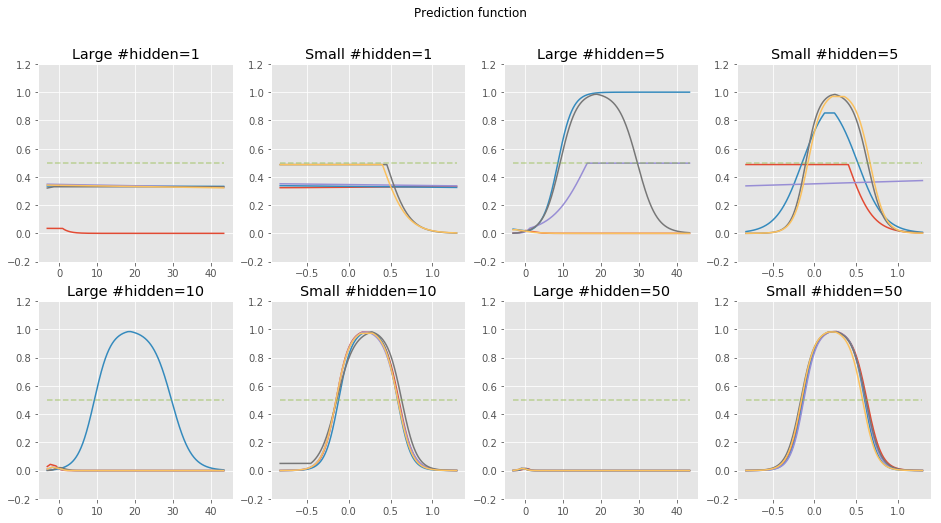

In [85]:
a, b = 2, 4
plt.figure(figsize=[4*b, 4*a])
i = 1
for h in [1, 5, 10, 50]:

    plt.subplot(a, b, i)
    i += 1
    predictions = preds.get_group(h).sample(5)['pred_test']
    for p in predictions:
        plt.plot(xtest, p[:, 1])
    plt.plot([min(xtest), max(xtest)], [0.5, 0.5], '--', alpha=0.5)
    plt.ylim([-.2, 1.2])
    plt.title('Large #hidden=%d'%h)

    plt.subplot(a, b, i)
    i += 1
    predictions = preds_small.get_group(h).sample(5)['pred_test']
    for p in predictions:
        plt.plot(xtest_small, p[:, 1])
    plt.plot([min(xtest_small), max(xtest_small)], [0.5, 0.5], '--', alpha=0.5)
    plt.ylim([-.2, 1.2])    
    plt.title('Small #hidden=%d'%h)
plt.suptitle('Prediction function')
plt.show()
    

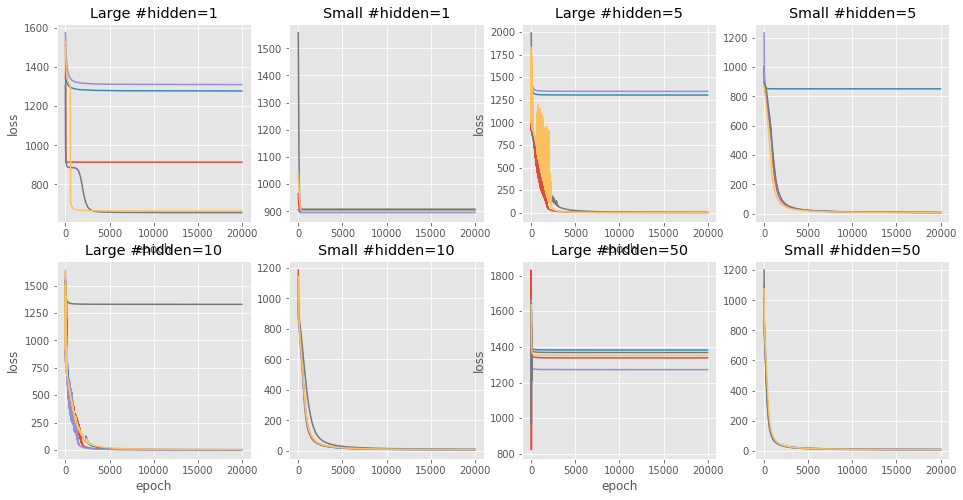

In [81]:
a, b = 2, 4
plt.figure(figsize=[4*b, 4*a])
i = 1
for h in [1, 5, 10, 50]:

    plt.subplot(a, b, i)
    i += 1
    predictions = preds.get_group(h).sample(5)['losses']
    for p in predictions:
        plt.plot(p)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Large #hidden=%d'%h)

    plt.subplot(a, b, i)
    i += 1
    predictions = preds_small.get_group(h).sample(5)['losses']
    for p in predictions:
        plt.plot(p)
    plt.title('Small #hidden=%d'%h)

#     plt.show()
    

In [27]:
maxidx = max(results.weights[0].keys())
minidx = min(results.weights[0].keys())

In [48]:
h = 5
predictions = preds.get_group(h).sample(5)['weights']

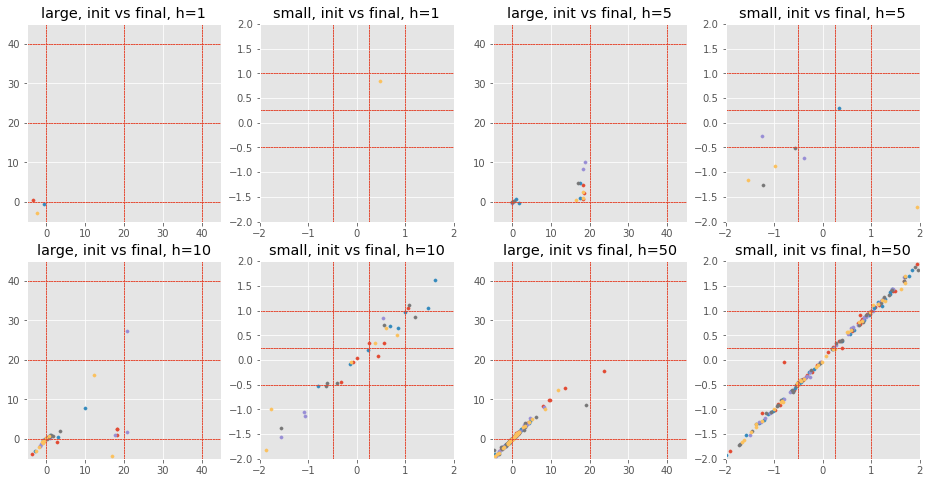

In [88]:
num_samples = 5
a, b = 2, 4
plt.figure(figsize=[4*b, 4*a])
i = 1
for h in [1, 5, 10, 50]:
    pl = preds.get_group(h).sample(num_samples)['weights']
    ps = preds.get_group(h).sample(num_samples)['weights']
    ml = results.means[0]
    ms = results_small.means[0]
    plt.subplot(a, b, i)
    i+=1
    for key in pl.keys():
        temp = pl[key]
        relus0 = -temp[minidx]['0.bias']/temp[minidx]['0.weight'].flatten()
        relusf = -temp[maxidx]['0.bias']/temp[maxidx]['0.weight'].flatten()
        plt.scatter(relusf, relus0, s=10.)
        for mean in ml:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
            plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlim([-5, 45])
        plt.ylim([-5, 45])
        plt.title('large, init vs final, h=%d'%(h))

    plt.subplot(a, b, i)
    i+=1
    for key in ps.keys():
        temp = ps[key]
        relus0 = -temp[minidx]['0.bias']/temp[minidx]['0.weight'].flatten()
        relusf = -temp[maxidx]['0.bias']/temp[maxidx]['0.weight'].flatten()
        plt.scatter(relusf, relus0, s=10.)
        for mean in ms:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
            plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.title('small, init vs final, h=%d'%(h))

plt.show()

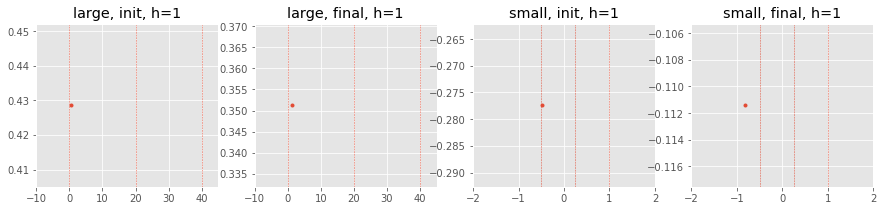

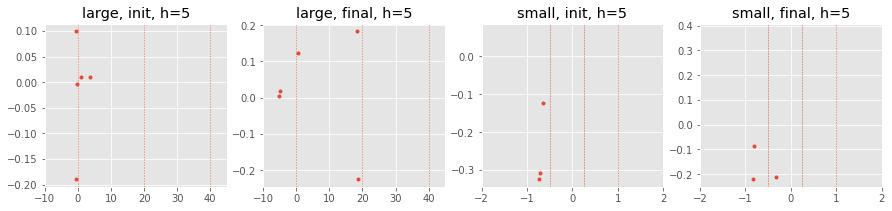

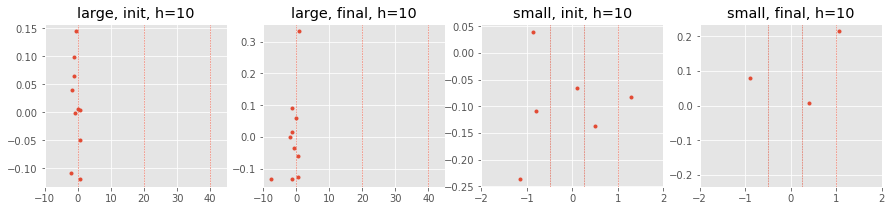

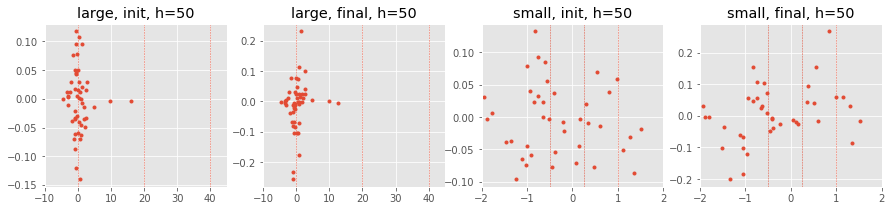

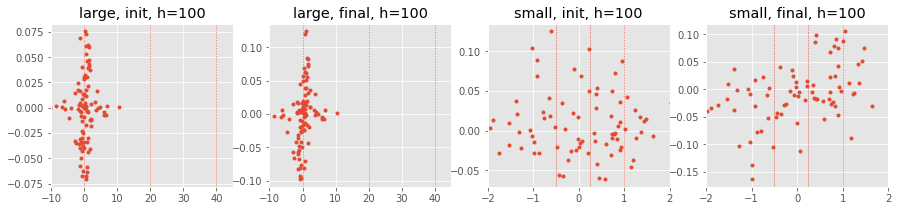

In [101]:
num_samples = 1
for h in [1, 5, 10, 50, 100]:
    pl = preds.get_group(h).sample(num_samples)['weights']
    ps = preds.get_group(h).sample(num_samples)['weights']
    ml = results.means[0]
    ms = results_small.means[0]
    plt.figure(figsize=[15, 3])
    plt.subplot(141)
    for key in pl.keys():
        temp = pl[key]
        zs = -temp[minidx]['0.bias']/temp[minidx]['0.weight'].flatten()
        ws = temp[minidx]['0.weight'].flatten()
        ws *= temp[minidx]['2.weight'][1]
        
        plt.plot(zs, ws, '.')
        for mean in ml:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
#             plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlim([-10, 45])
#         plt.ylim([-5, 45])
        plt.title('large, init, h=%d'%(h))
    plt.subplot(142)
    for key in pl.keys():
        temp = pl[key]
        zs = -temp[maxidx]['0.bias']/temp[maxidx]['0.weight'].flatten()
        ws = temp[maxidx]['0.weight'].flatten() 
        ws *= temp[maxidx]['2.weight'][1]
        
        plt.plot(zs, ws, '.')
        for mean in ml:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
#             plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlim([-10, 45])
#         plt.ylim([-5, 45])
        plt.title('large, final, h=%d'%(h))

    plt.subplot(143)
    for key in ps.keys():
        temp = ps[key]
        zs = -temp[minidx]['0.bias']/temp[minidx]['0.weight'].flatten()
        ws = temp[minidx]['0.weight'].flatten()
        ws *= temp[minidx]['2.weight'][1]
        
        plt.plot(zs, ws, '.')
        for mean in ms:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
#             plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlim([-2, 2])
#         plt.ylim([-2, 2])
        plt.title('small, init, h=%d'%(h))
        
    plt.subplot(144)
    for key in ps.keys():
        temp = ps[key]
        zs = -temp[maxidx]['0.bias']/temp[maxidx]['0.weight'].flatten()
        ws = temp[maxidx]['0.weight'].flatten()
        ws *= temp[maxidx]['2.weight'][1]

        plt.plot(zs, ws, '.')
        for mean in ms:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
#             plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlim([-2, 2])
#         plt.xlim([-10, 10])


#         plt.ylim([-2, 2])
        plt.title('small, final, h=%d'%(h))

    plt.show()